In this assignment I will be impolementing Robust PCA Image Segmentation

In [2]:
import os
import sys
import PIL
import numpy as np
from glob import glob
import moviepy.editor as mpe
import matplotlib.pyplot as pt

from typing import Tuple, Any

In [3]:
# Now we need to set up a tolerance as a stopage threshold
TOL: float = 1.E-8
# and a max iteration as well
MAX_ITER: int = 3

In [4]:
def load_video(path: str) -> Tuple[Any, float]:
    try:
        video = mpe.VideoFileClip(path)
        print(f"Loaded video file from: {path}")
        print(f"Duration of loaded video: {video.duration}")
    except FileNotFoundException as err:
        print("Cannot find video file")
        raise err
    
    return video, video.duration, video.fps

In [5]:
def to_grayscale(mat: np.ndarray) -> np.ndarray:
    return np.dot(mat[...,:3], [0.299, 0.587, 0.114])

In [6]:
def scale_video(video, fps: int, scale_percent: int) -> Tuple[Any, int]:
    orig_n, orig_m, _ = video.get_frame(0).shape
    print(orig_n, orig_m)
    frame_n = int(orig_n * (scale_percent/100))
    frame_m = int(orig_m * (scale_percent/100))
    
    output: np.ndarray = np.zeros((frame_n*frame_m, fps*int(video.duration)))
    for frame in range(fps*int(video.duration)):
        current_frame = video.get_frame(frame/float(100))
        gray_frame = to_grayscale(current_frame)
        processed_image = PIL.Image.fromarray(gray_frame).resize(size=(frame_m, frame_n)) # pillow does width, height so switch the values
        output[:, frame] = np.array(processed_image).reshape(frame_n*frame_m)
    
    return output, frame_n, frame_m

In [7]:
path: str = "data/video.avi"
video, duration, fps = load_video(path)
num_frames = round(duration*fps)
video.subclip(0, 60).ipython_display(width=450)

t:  42%|████▏     | 177/420 [00:00<00:00, 1769.46it/s, now=None]

Loaded video file from: data/video.avi
Duration of loaded video: 113.57
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [8]:
print(f"Video duration: {duration}")
print(f"Video fps: {fps}")
print(f"Number of Frames: {num_frames}")

Video duration: 113.57
Video fps: 7.0
Number of Frames: 795


Now we can set the resolution of the image, 240 by 320 is large for visualization, so lets shrink a display version to 60x80 and then run this on the full video after it is validated

We are also going to cheat and simulate that the video is running at 100fps so that the noise is amplified

In [9]:
scale_percent: int = 25
HR, hr_n, hr_m = scale_video(video, 100, 100)
M, frame_n, frame_m = scale_video(video, 100, scale_percent)

240 320
240 320


In [10]:
print(f"Each image is now ({frame_n}, {frame_m})")
print(f"Data matrix shape is: {M.shape}")

Each image is now (60, 80)
Data matrix shape is: (4800, 11300)


The low rez image:

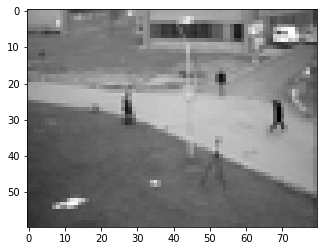

In [11]:
pt.imshow(M[:, 0].reshape(frame_n, frame_m), cmap="gray")

The corresponding high rez image:

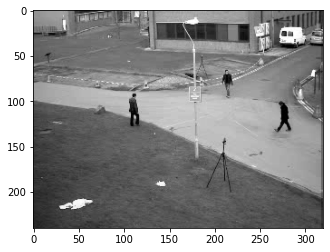

In [12]:
pt.imshow(HR[:, 0].reshape(hr_n, hr_m), cmap='gray')

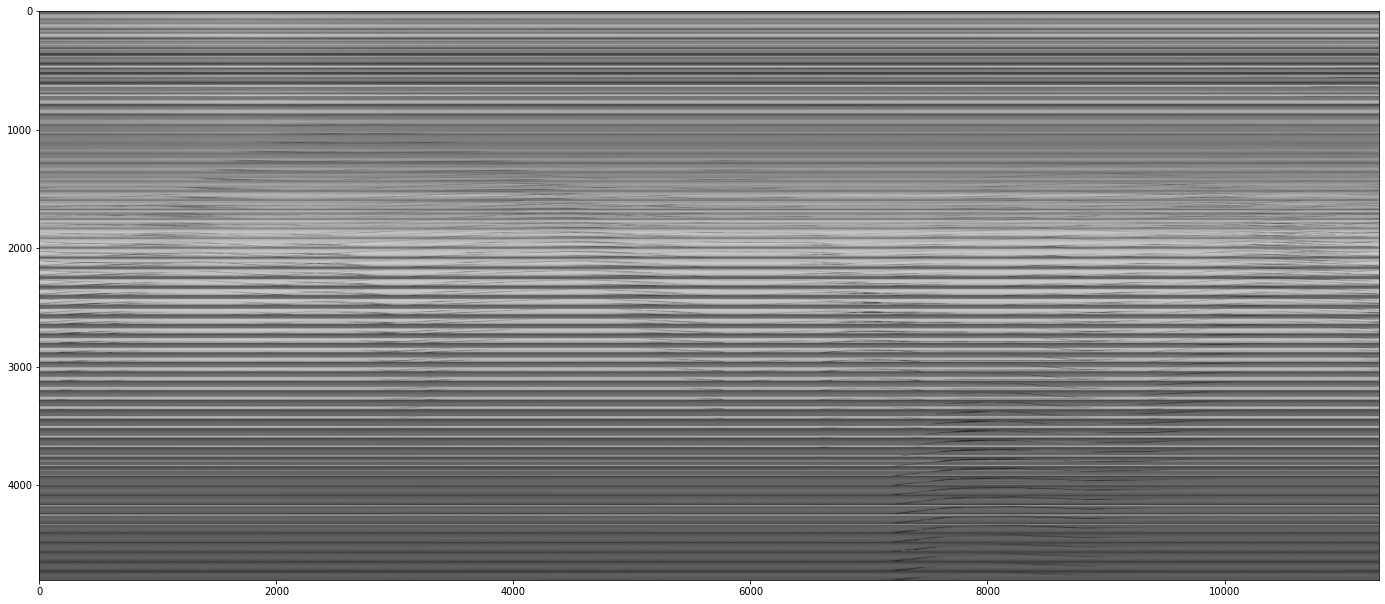

In [13]:
pt.figure(figsize=(24, 24))
pt.imshow(M, cmap='gray')

Time to use SVD to process this first!

First lets calculate U, S, VT

Also, as an aside (for an economy SVD where you truncate U and S to have rank m)
U is of shape n-by-m
S is of shape m-by-m
and VT is of shape m-by-n

so if you multiply them straight across you end up with an n-by-m matrix (which is your input)

you can "approximate" the original matrix with a lower rank by decreasing 'm' 

in this case, we make m = 1, so that each row is a linear combination of the first row (and that linear encoding is defined by the now vertical n-by-1 vector U)

In our case, we choose m = 1 because ideally this will give us the background because there is not enough information to render the "noise" i.e the small details that move in every frame. We hope that the background does not move every frame

Up first I will do this to our low rez video and then I will do it to our hi rez video


Helper function to do the low rank multiplication

In [14]:
u, s, vt = np.linalg.svd(M, full_matrices=False)  # economy SVD

In [15]:
def get_rank_n_matrix(u, s, vt, rank) -> np.ndarray:
    return u[:, :rank] @ np.diag(s[:rank]) @ vt[:rank, :]

In [16]:
low_rank = get_rank_n_matrix(u, s, vt, 1)

In [17]:
print(low_rank.shape)

(4800, 11300)


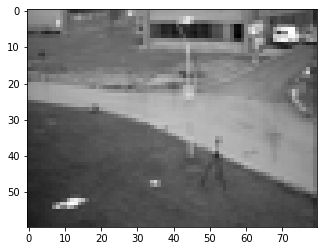

In [18]:
pt.imshow(low_rank[:, 0].reshape(frame_n, frame_m), cmap='gray')

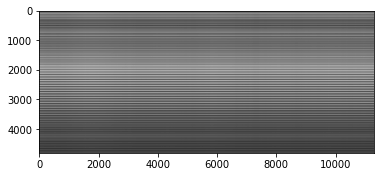

In [19]:
pt.imshow(low_rank, cmap='gray')

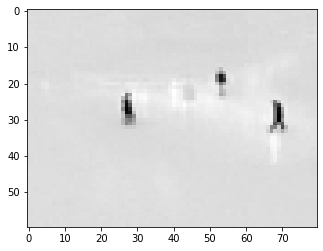

In [20]:
pt.imshow((M[:, 0] - low_rank[:, 0]).reshape(frame_n, frame_m), cmap='gray')

Now time to use something a little different

Robust PCA

Algorithm of Principal Component Pursuit by Alternating Directions

- L = Low Rank Approximation
- S = Sparse Matrix Approximation
- Y = Something

In [24]:
def shrink(M, tau):
    # return 1 or 0 * max(abs(M)-tau, 0)
    return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

def svd_threshold(M, tau):
    u, s, vt = np.linalg.svd(M, full_matrices=False)
    # return u @ shrink(s) @ vt
    return np.dot(u, np.dot(np.diag(shrink(s, tau)), vt))

def pcpad(M, maxiter=10, tol=None):
    err = np.Inf
    Sk = np.zeros(M.shape)
    Yk = np.zeros(M.shape)
    Lk = np.zeros(M.shape)
    
    mu = np.prod(M.shape) / (4 * np.linalg.norm(M, ord=1))
    mu_inv = 1/mu
    
    lam = 1/np.sqrt(np.max(M.shape))
    
    if tol is None:
        tol = 1e-7 * np.linalg.norm(M, 'fro')
    
    for i in range(maxiter):
        if (err <= tol):
            break
            
        Lk = svd_threshold(
            M - Sk - (mu_inv*Yk), mu_inv
        )
        Sk = shrink(
            M - Lk + (mu_inv*Yk), mu_inv*lam
        )
        Yk = Yk + mu*(M - Lk - Sk)
        
        err = np.linalg.norm((M - Lk - Sk), 'fro')
        
        print(f"Error for iteration {i} : {err}")
        
    return Lk, Sk

In [25]:
L, S = pcpad(M)

Error for iteration 0 : 0.7358032253509469
Error for iteration 1 : 0.777255138019565
Error for iteration 2 : 0.7838592547732897
Error for iteration 3 : 0.7380554733200811
Error for iteration 4 : 0.6367885182277853
Error for iteration 5 : 0.4929810631672651
Error for iteration 6 : 0.3572836264475872
Error for iteration 7 : 0.2533697192492872
Error for iteration 8 : 0.17862725235660531
Error for iteration 9 : 0.12597419881467659


In [23]:
print(L.shape)
print(S.shape)

NameError: name 'L' is not defined

In [1]:
import os
import sys
import scipy
import numpy as np
from glob import glob
import moviepy.editor as mpe
import matplotlib.pyplot as pt

from typing import Tuple, Any

In [2]:
# Now we need to set up a tolerance as a stopage threshold
TOL: float = 1.E-8
# and a max iteration as well
MAX_ITER: int = 3

In [3]:
# load our video from disk
path: str = "data/video.avi"
try:
    video = mpe.VideoFileClip(path)
    print(f"Loaded video file from: {path}")
    print(f"Duration of loaded video: {video.duration}")
except FileNotFoundException as err:
    print("Cannot find video file")
    raise err

Loaded video file from: data/video.avi
Duration of loaded video: 113.57


In [4]:
#Play a subclip of the video
video.subclip(0,50).ipython_display(width=450)

t:  48%|████▊     | 169/350 [00:00<00:00, 1685.10it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [5]:
# time to figure out the dimensions of each frame
def get_dims(video) -> Tuple[int]:
    frame = video.get_frame(0)
    return frame.shape

print(f"Dimension of each frame of our video is: {get_dims(video)}")

Dimension of each frame of our video is: (240, 320, 3)


In [6]:
# we will also be converting the video to grayscale to make our analysis easier
def to_grayscale(matrix) -> np.ndarray:
    return np.dot(matrix[...,:3], [0.299, 0.597, 0.114])

In [7]:
# we will now also have to turn our frames into one coherent matrix
def video_to_matrix(video, to_gray: bool=True) -> np.ndarray:
    (r, c, d) = get_dims(video)
    print(r, c, d)
    num_frames: int = round(video.fps * video.duration)
    output: np.ndarray = np.zeros((r*c, num_frames, d))
    print(num_frames)
    
    for i in range(num_frames):
        output[:, i, :] = video.get_frame(i).reshape(r*c, 3)
        
    if to_gray:
        return to_grayscale(output)
    else:
        return output

In [8]:
mat = video_to_matrix(video)
np.save("data/video_matrix.npy", mat)
print(f"output shape: {mat.shape}")

240 320 3
795
output shape: (76800, 795)


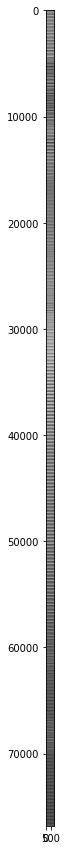

In [9]:
# time to check what the input data looks like
pt.figure(figsize=(15, 15))
pt.imshow(mat, cmap='gray')
pt.show()

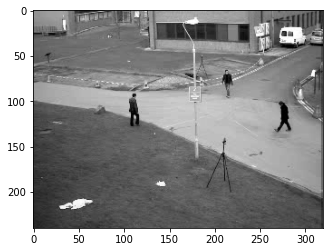

In [12]:
pt.imshow(mat[:,0].reshape(240, 320), cmap="gray")

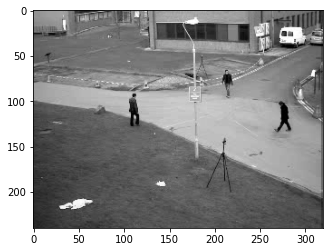

In [13]:
pt.imshow(mat.reshape(240, 320,795)[...,0], cmap="gray")

## Robust PCA via Primary Component Pursuit

https://github.com/dganguli/robust-pca/blob/master/r_pca.py

In [15]:

from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def frobenius_norm(M):
        return np.linalg.norm(M, ord='fro')

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.frobenius_norm(self.D)

        #this loop implements the principal component pursuit (PCP) algorithm
        #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
            Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
            err = self.frobenius_norm(self.D - Lk - Sk)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [16]:
L, S = R_pca(mat).fit()

iteration: 1, error: 2.464095660017103
iteration: 2, error: 0.0003496965327409113


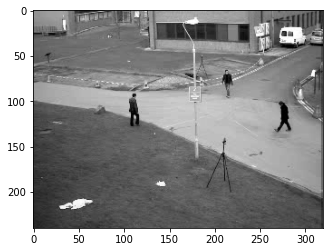

In [18]:
pt.imshow(mat[:,0].reshape(240, 320), cmap="gray")

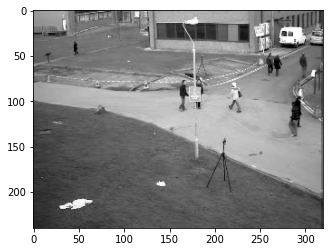

In [35]:
pt.imshow(L[:,20].reshape(240, 320), cmap='gray')

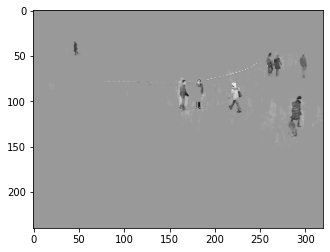

In [36]:
pt.imshow(S[:,20].reshape(240, 320), cmap='gray')

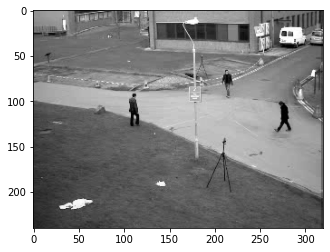

In [22]:
pt.imshow((L[:,0].reshape(240, 320) - S[:,0].reshape(240, 320)), cmap='gray')

[144.06200009 145.07200005 146.08200001 ...  70.75699993  51.56700002
  46.51700017]
